# Palindromic Deep Learning
Let's dig deeper into what we mean by a "palindromic" deep learning model. A palindrome is a sequence that reads the same forwards and backwards: for example, ABA is a palindrome.

A more appropriate definition for deep learning is to describe a sequence in terms of static values and transitions: A _AB_ B _BA_ A. That is, there are 2 unique symbols A and B, and 2 unique transitions (_AB_, _BA_) between those values. In deep learning, the "symbols" would be hidden vectors and the "transitions" would be deep learning transformation layers like Dense and LeakyReLU.

In a "Palindromic" Deep Learning model, the two instances of hidden vectors A in the first and second half should match (approximately), and the effects of the _AB_ and _BA_ transformation layers should be (approximately) mutually inverting.

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [20]:
# def get_layer(model, name):
#     for layer in model.layers:
#         if layer.name == name:
#             return layer

# def create_model(shape, layer):
#     model = tf.keras.Sequential()
#     model.add(tf.keras.Input(shape=shape))
#     model.add(layer)
#     model.compile(optimizer='sgd', loss='mse')
#     return model

def delta_check(data1, data2, epsilon=1e-2):
    delta = np.abs(data1 - data2)
    return np.max(delta) < epsilon

# A Simple Palindromic Deep Learning Model

Next, using the techniques shown in Preso #1, we will create a simple autoencoder in Keras that is a palindrome: a series of "forward" and "inverted" layers in matched pairs. 

First, let's crib some MNIST code from other Keras examples and then design the model.

In [21]:
from keras.datasets import mnist

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)


(60000, 784)
(10000, 784)


The model will create a mirrored sequence of layers based on the techniques for inverting LeakyReLU and Dense demonstrated in Preso #1. We will use the Tensorflow function tf.linalg.pinv to implement the Moore-Penrose pseudo-inverse function. The pseudo-inverse algorithm will be run after every batch during the training operation, since the end-of-batch applies loss values.

We will add a monitor that compares the outputs of Dense layers 'a' and 'b', considering them to be the A and B from the above explanation of palindromes.

We are going to add a monitor which taps the outputs for the forward and inverted values of A, and at the end of each training epoch we will check that they are approximately the same. To do this, the easy way is to create three nested models.

In [22]:
def create_nested_models():
    alpha = 0.3
    input_img = tf.keras.Input(shape=(784,))
    forward_a = tf.keras.layers.Dense(192, name='a')
    forward_b = tf.keras.layers.Dense(128, name='b')
    forward_c = tf.keras.layers.Dense(64, name='c')
    inverted_c = tf.keras.layers.Lambda(lambda x: tf.matmul(x - forward_c.bias, tf.linalg.pinv(forward_c.kernel)), name='inv_c')
    inverted_b = tf.keras.layers.Lambda(lambda x: tf.matmul(x - forward_b.bias, tf.linalg.pinv(forward_b.kernel)), name='inv_b')
    inverted_a = tf.keras.layers.Lambda(lambda x: tf.matmul(x - forward_a.bias, tf.linalg.pinv(forward_a.kernel)), name='inv_a')

    model_a = tf.keras.Sequential(name='model_a')
    model_a.add(tf.keras.Input(shape=(784,)))
    model_a.add(tf.keras.layers.Dropout(0.3))
    model_a.add(forward_a)
    model_a.add(tf.keras.layers.LeakyReLU(alpha))

    model_inv_a = tf.keras.Sequential(name='model_inv_a')
    model_inv_a.add(model_a)
    model_inv_a.add(forward_b)
    model_inv_a.add(tf.keras.layers.LeakyReLU(alpha))
    model_inv_a.add(forward_c)
    model_inv_a.add(inverted_c)
    model_inv_a.add(tf.keras.layers.LeakyReLU(1/alpha, name='leaky_relu_inv_b'))
    model_inv_a.add(inverted_b)

    autoencoder = tf.keras.Sequential(name='autoencoder')
    autoencoder.add(model_inv_a)
    autoencoder.add(tf.keras.layers.LeakyReLU(1/alpha, name='leaky_relu_inv_a'))
    autoencoder.add(inverted_a)

    autoencoder.compile(optimizer='adam', loss='mse')
    return model_a, model_inv_a, autoencoder

model_a, model_inv_a, autoencoder = create_nested_models()
autoencoder.predict(np.zeros((1, 784)))
model_a.summary()
model_inv_a.summary()
autoencoder.summary()


The following Variables were used a Lambda layer's call (inv_c), but
are not present in its tracked objects:
  <tf.Variable 'c/kernel:0' shape=(128, 64) dtype=float32>
  <tf.Variable 'c/bias:0' shape=(64,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (inv_b), but
are not present in its tracked objects:
  <tf.Variable 'b/kernel:0' shape=(192, 128) dtype=float32>
  <tf.Variable 'b/bias:0' shape=(128,) dtype=float32>
It is possible that this is intended behavior, but it is more likely
an omission. This is a strong indication that this layer should be
formulated as a subclassed Layer rather than a Lambda layer.
The following Variables were used a Lambda layer's call (inv_a), but
are not present in its tracked objects:
  <tf.Variable 'a/kernel:0' shape=(784, 192) dtype=fl

Model: "model_a"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_1 (Dropout)         (None, 784)               0         
                                                                 
 a (Dense)                   (None, 192)               150720    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 192)               0         
                                                                 
Total params: 150,720
Trainable params: 150,720
Non-trainable params: 0
_________________________________________________________________
Model: "model_inv_a"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_a (Sequential)        (None, 192)               150720    
                                                                 
 b (Dense)                   (No

In [23]:
class MonitorDeltas(tf.keras.callbacks.Callback):
    def __init__(self, forward, inverse, sample):
        super(MonitorDeltas, self).__init__()
        self._forward = forward
        self._inverse = inverse
        self._sample = sample
        self._deltas = []

    def on_epoch_end(self, epoch, logs=None):
        pred_forward = self._forward.predict(self._sample)
        pred_inverse = self._inverse.predict(self._sample)
        delta = np.mean(np.abs(pred_forward - pred_inverse))
        self._deltas.append(delta)

    def get_deltas(self):
        return self._deltas


In [24]:
num_epochs =  1000  # @param {type: "slider", min:2, max:1000}
batch_size = 3072

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
monitor_deltas = MonitorDeltas(model_a, model_inv_a, np.reshape(x_test[0], (1, 784)))
history = autoencoder.fit(x_train, x_train,
                epochs=num_epochs,
                batch_size=batch_size,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[early_stopping, monitor_deltas],
                verbose=2)


Epoch 1/1000
20/20 - 3s - loss: 0.1188 - val_loss: 0.0722 - 3s/epoch - 127ms/step
Epoch 2/1000
20/20 - 1s - loss: 0.0716 - val_loss: 0.0579 - 1s/epoch - 73ms/step
Epoch 3/1000
20/20 - 1s - loss: 0.0583 - val_loss: 0.0481 - 1s/epoch - 73ms/step
Epoch 4/1000
20/20 - 1s - loss: 0.0494 - val_loss: 0.0417 - 1s/epoch - 73ms/step
Epoch 5/1000
20/20 - 2s - loss: 0.0437 - val_loss: 0.0373 - 2s/epoch - 75ms/step
Epoch 6/1000
20/20 - 1s - loss: 0.0398 - val_loss: 0.0340 - 1s/epoch - 74ms/step
Epoch 7/1000
20/20 - 1s - loss: 0.0368 - val_loss: 0.0315 - 1s/epoch - 73ms/step
Epoch 8/1000
20/20 - 1s - loss: 0.0344 - val_loss: 0.0294 - 1s/epoch - 73ms/step
Epoch 9/1000
20/20 - 1s - loss: 0.0325 - val_loss: 0.0276 - 1s/epoch - 73ms/step
Epoch 10/1000
20/20 - 1s - loss: 0.0309 - val_loss: 0.0261 - 1s/epoch - 73ms/step
Epoch 11/1000
20/20 - 1s - loss: 0.0296 - val_loss: 0.0248 - 1s/epoch - 73ms/step
Epoch 12/1000
20/20 - 1s - loss: 0.0284 - val_loss: 0.0237 - 1s/epoch - 73ms/step
Epoch 13/1000
20/20 - 1s

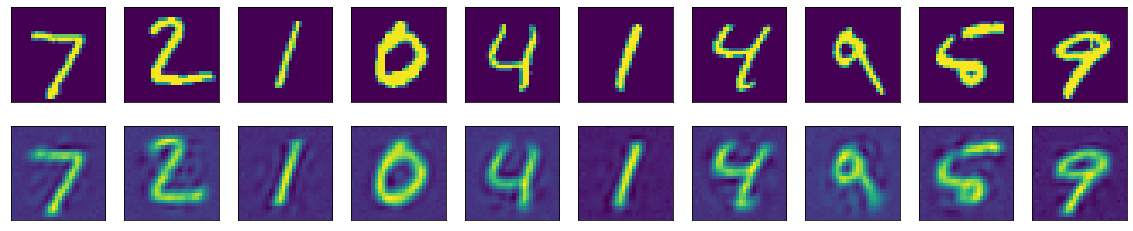

In [25]:
n = 10  # How many digits we will display
# display_imgs = x_test.take(n)
predicted_imgs = autoencoder.predict(x_test)
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predicted_imgs[i].reshape(28, 28))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

As you can see, this design is a decent autoencoder. Not the best around, but the output is recognizable. 

In [30]:
def dual_plot(data1, data2, name1, name2):
    assert len(data1) == len(data2)
    xaxis = [x for x in range(len(data1))]
    # create figure and axis objects with subplots()
    fig,ax = plt.subplots()
    # make a plot
    ax.plot(xaxis, data1,
            color="red")
    # set x-axis label
    ax.set_xlabel("epoch", fontsize = 14)
    # set y-axis label
    ax.set_ylabel(name1,
                color="red",
                fontsize=14)
    ax2=ax.twinx()
    # make a plot with different y-axis using second axis object
    ax2.plot(xaxis, data2,color="blue")
    # if data3 is not None:
    #     ax2.plot(xaxis, data3,color="green")
    ax2.set_ylabel(name2,color="blue",fontsize=14)
    plt.show()

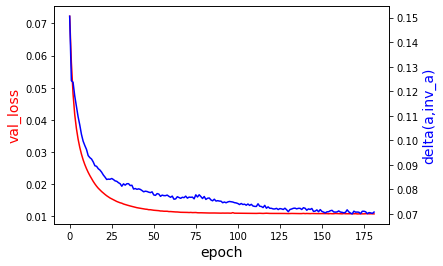

In [31]:
left_data = np.asarray(history.history['val_loss'], dtype='float64')
deltas = monitor_deltas.get_deltas()
dual_plot(left_data, deltas, 'val_loss', 'delta(a,inv_a)')